This notebook serves as a demo notebook detailing the full analysis pipeline for deriving flexibility metrics from the incomplete shape drawing task using the CoSE model, alongside a sample (sequential) pass to all the five signatures of the CoSE model. It uses drawings of cats from the QuickDraw dataset for demonstration purpose. 

# Import modules

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import json
import os
import linecache

# Get model architecture

In [3]:
model_signature_directory = '../thesis/model_architecture.csv'
model = tf.saved_model.load("../pretrained_model/saved_model_with_signatures")

if not os.path.exists(model_signature_directory):
    # Collecting signature details
    signatures_data = []

    # Iterate over each signature in the model
    for key, signature in model.signatures.items():
        # Initialize dictionaries for current signature's inputs and outputs
        inputs_dict = {}
        outputs_dict = {}

        # Iterate over inputs and outputs, filling in the dictionaries
        for input_key, input_val in signature.structured_input_signature[1].items():
            inputs_dict[input_key] = str(input_val.dtype.name)

        for output_key, output_val in signature.structured_outputs.items():
            outputs_dict[output_key] = str(output_val.dtype.name)

        # Append the current signature's details to the list
        signatures_data.append({
            "Signature Key": key,
            "Inputs": inputs_dict,
            "Outputs": outputs_dict
        })

    # Convert list of signature data into a DataFrame for visualization
    df_signatures = pd.DataFrame(signatures_data)

    df_inputs = df_signatures["Inputs"].apply(pd.Series)
    df_outputs = df_signatures["Outputs"].apply(pd.Series)
    df_signatures = pd.concat([df_signatures.drop(['Inputs', 'Outputs'], axis=1), df_inputs, df_outputs], axis=1)
    df_signatures.set_index('Signature Key', drop=True, inplace=True)
    df_signatures.to_csv(model_signature_directory, index=True)
else:
    df_signatures = pd.read_csv(model_signature_directory, index_col='Signature Key')

In [4]:
df_signatures

,target_seq_len,embedding_sample,target_pos,inp_embeddings,inp_pos,input_stroke,input_seq_len,pen,seq_len,stroke,embedding_sample.1,sigma,mu,pi,position_sample
Signature Key,,,,,,,,,,,,,,,
decode_stroke,int32,float32,NaN,NaN,NaN,NaN,NaN,float32,int32,float32,NaN,NaN,NaN,NaN,NaN
predict_embedding,NaN,NaN,float32,float32,float32,NaN,NaN,NaN,NaN,NaN,float32,float32,float32,float32,NaN
predict_position,NaN,NaN,NaN,float32,float32,NaN,NaN,NaN,NaN,NaN,NaN,float32,float32,float32,float32
encode_stroke,NaN,NaN,NaN,NaN,NaN,float32,int32,NaN,NaN,NaN,float32,NaN,NaN,NaN,NaN
forward_pass,int32,NaN,NaN,NaN,NaN,float32,int32,float32,int32,float32,float32,NaN,NaN,NaN,NaN


# Preprocess drawings

## Visualize sample drawing (first row)

before [[[414.48199462890625, 410.364013671875, 403.54901123046875, 395.802001953125, 389.87298583984375, 384.35699462890625, 373.40399169921875, 365.4259948730469, 357.45001220703125, 352.2409973144531, 342.8789978027344, 339.5119934082031, 339.9620056152344, 343.1789855957031, 346.9419860839844, 350.7340087890625, 357.48699951171875, 359.8890075683594, 362.3299865722656, 364.322998046875, 364.677001953125, 350.593994140625, 341.8160095214844, 319.9540100097656, 311.177001953125, 297.6260070800781, 284.0320129394531, 261.2560119628906, 251.906005859375, 239.7209930419922, 229.60000610351562, 218.16600036621094, 214.43099975585938, 212.5449981689453, 212.56300354003906, 219.68299865722656, 230.177001953125, 242.10000610351562, 273.4639892578125, 285.5740051269531, 308.1730041503906, 329.3689880371094, 373.6130065917969, 420.0690002441406, 446.9949951171875, 472.5610046386719, 513.7899780273438, 551.1010131835938, 584.2059936523438, 595.7969970703125, 609.0369873046875, 621.237976074218

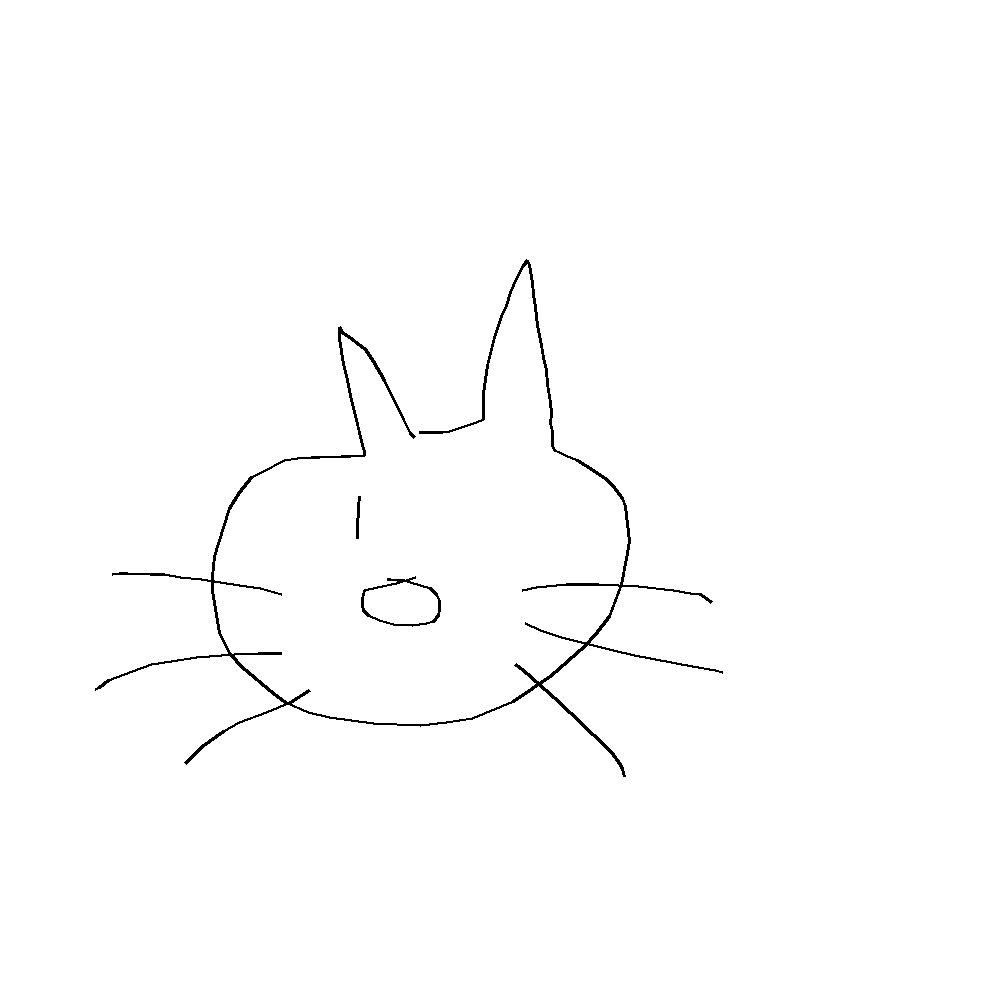

In [5]:
import json
from PIL import Image, ImageDraw
from IPython.display import display  

# read ndjson lines
lines = open('data/raw_cat.ndjson','r').readlines()
# grab the first line, JSON parse it and fetch the 'drawing' array
raw_drawing = json.loads(lines[0])['drawing']

print('before',raw_drawing)
# zip x,y coordinates for each point in every polyline
polylines = list((zip(polyline[0], polyline[1]) for polyline in raw_drawing))
# notice how the data is shuffled to (x1,y1),(x2,y2) order
print('after',polylines)

# make a new image
pil_img = Image.new("RGB", (1000, 1000), (255,255,255))
# get a drawing context
d = ImageDraw.Draw(pil_img)
# render each polyline
for polyline in polylines:
    # Flatten the list of tuples into a single list of coordinates
    polyline_flat = [coord for point in polyline for coord in point]
    d.line(polyline_flat,fill=(0, 0, 0), width=3)

# display image
display(pil_img)

## Parse preprocessed drawings into TFRecord

Type the following in the terminal to convert raw ndjson file to TFRecord 
```bash
python data_preprocessing.py --data_dir data --mode test --num_shards 1
``` 

In [6]:
def _parse_function(example_proto):
     # Define the feature structure of TF_example
    feature_description = {
        'key': tf.io.FixedLenFeature([], tf.string),
        'label_id': tf.io.FixedLenFeature([], tf.string),
        'ink': tf.io.VarLenFeature(tf.float32),
        'stroke_length': tf.io.VarLenFeature(tf.int64),
        'shape': tf.io.FixedLenFeature([3], tf.int64),
        'num_strokes': tf.io.FixedLenFeature([], tf.int64)
    }

    # Parse the input tf.train.Example proto based on feature_description
    return tf.io.parse_single_example(example_proto, feature_description)

In [7]:
tfrecord_path = 'data/raw_cat-00000-of-00001.tfrecord'
raw_drawing_dataset = tf.data.TFRecordDataset(tfrecord_path)
parsed_drawing_dataset = raw_drawing_dataset.map(_parse_function)

parsed_drawing_dataset

<_MapDataset element_spec={'ink': SparseTensorSpec(TensorShape([None]), tf.float32), 'stroke_length': SparseTensorSpec(TensorShape([None]), tf.int64), 'key': TensorSpec(shape=(), dtype=tf.string, name=None), 'label_id': TensorSpec(shape=(), dtype=tf.string, name=None), 'num_strokes': TensorSpec(shape=(), dtype=tf.int64, name=None), 'shape': TensorSpec(shape=(3,), dtype=tf.int64, name=None)}>

In [12]:
# In this code, I just sample the first record
for parsed_features in parsed_drawing_dataset.take(1):
    print("Drawing: ", ink)
    shape = parsed_features['shape']
    print("Shape of Drawing: ", shape)
    stroke_length = tf.sparse.to_dense(parsed_features['stroke_length'])
    print("Stroke length: ", stroke_length)
    
    # Reshape ink data to original dimensions (num_strokes, max_len, 4)
    reshaped_ink = tf.reshape(ink, shape)

Drawing:  tf.Tensor(
[-0.03286448 -0.5109423   0.         ...  0.          0.
  0.        ], shape=(5400,), dtype=float32)
Shape of Drawing:  tf.Tensor([  9 150   4], shape=(3,), dtype=int64)
Stroke length:  tf.Tensor([150  10  11   8  12  12  12  28   4], shape=(9,), dtype=int64)


## Undo preprocessing and do visualization again

In [9]:
from undo_data_preprocessing import undo_preprocessing

lines = open('data/raw_cat.ndjson','r').readlines()
statistics_json_path = "data/cat_statistics.json"
reversed_strokes = undo_preprocessing(reshaped_ink, stroke_length, raw_drawing, statistics_json_path)

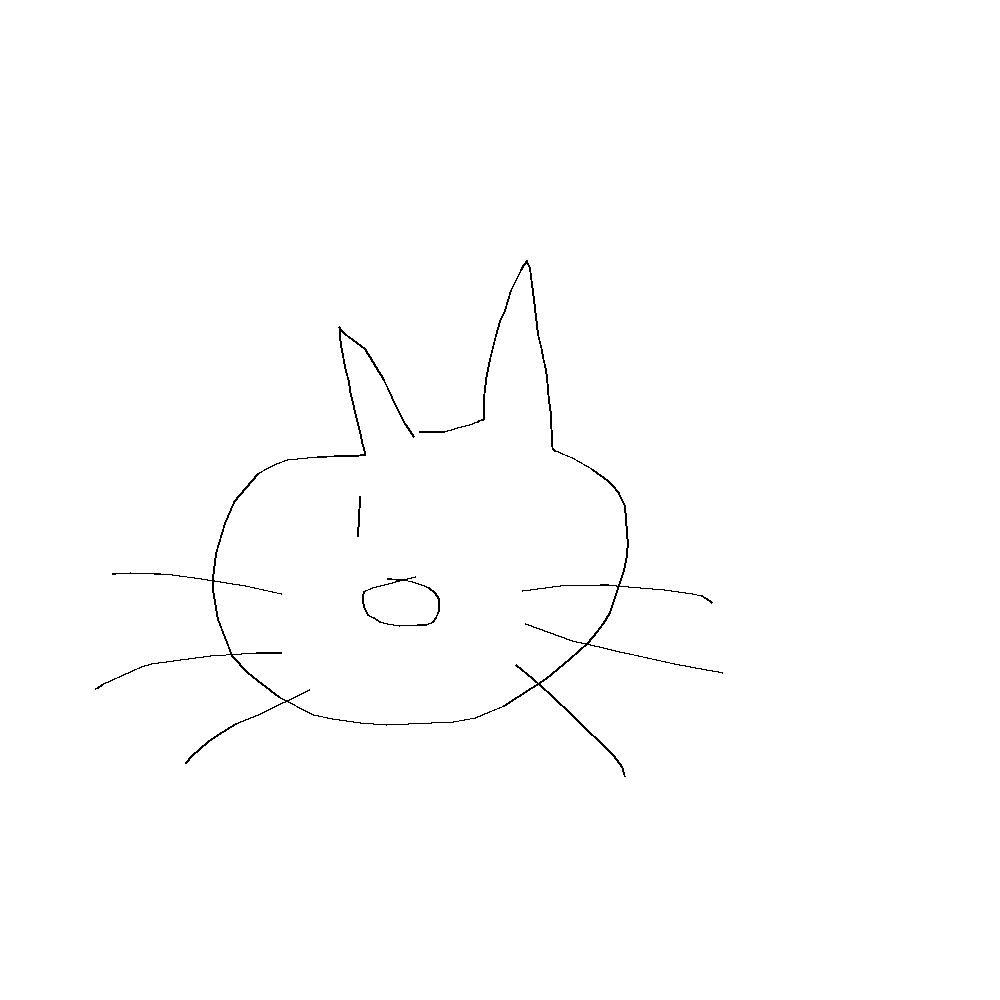

In [10]:
from stroke_visualization import visualize_stroke
visualize_stroke(reversed_strokes)

# Operationalize flexibility

In [ ]:
tf.expand_dims(reshaped_ink[:1, 0, :2], axis=0)
tf.expand_dims(encoded_embedding_sample[:, :], axis=0)

In [13]:
from calculate_flexibility import calculate_flexibility_measures

# Calculate flexibility measures
flexibility_measures = calculate_flexibility_measures(model, reshaped_ink, stroke_length)

DEBUG: reshaped_ink shape: (9, 150, 4)
DEBUG: stroke_length shape: (9,)
DEBUG: input_stroke shape (gathered from reshaped_ink): (9, 150, 3)
DEBUG: encoded_embedding_sample shape: (9, 8)
DEBUG: For stroke 0: input_position shape: (1, 1, 2), input_embedding shape: (1, 1, 8)
DEBUG: For stroke 0: predict_position_result['position_sample'] shape: (1, 2)
DEBUG: For stroke 0: target_pos shape (after expand_dims): (1, 1, 2)
DEBUG: For stroke 0: predict_embedding_result[pi] shape: (1, 10)
DEBUG: For stroke 0: predict_embedding_result[sigma] shape: (1, 1, 10, 8)
DEBUG: For stroke 0: predict_embedding_result[embedding_sample] shape: (1, 8)
DEBUG: For stroke 0: predict_embedding_result[mu] shape: (1, 1, 10, 8)
DEBUG: For stroke 1: input_position shape: (1, 2, 2), input_embedding shape: (1, 2, 8)
DEBUG: For stroke 1: predict_position_result['position_sample'] shape: (1, 2)
DEBUG: For stroke 1: target_pos shape (after expand_dims): (1, 1, 2)
DEBUG: For stroke 1: predict_embedding_result[pi] shape: (

In [11]:
import numpy as np
from scipy.linalg import det, inv
from scipy.special import logsumexp
import tensorflow as tf

def calculate(model, reshaped_ink, stroke_length):
    '''
    Inputs: 
        1) model: pre-trained CoSE model
        2) reshaped_ink: preprocessed (normalized) ink
        3) stroke_length: length for each stroke
    '''
    
    # Load signatures of pre-trained models
    encode_stroke = model.signatures["encode_stroke"]
    predict_position = model.signatures["predict_position"]
    predict_embedding = model.signatures["predict_embedding"]

    # Get encoded vectors for each stroke
    encoded_result = encode_stroke(
        input_seq_len=tf.cast(stroke_length, tf.int32),
        input_stroke=tf.gather(reshaped_ink, indices=[0, 1, 3], axis=2) # x coordinate, y coordinate, and pen state
    )

    encoded_embedding_sample = encoded_result['embedding_sample']

    # Iterate through each stroke in the given drawing (ink) to predict the next stroke
    n_stroke, _, _ = reshaped_ink.shape

    # Initialize an numpy array to store entropy and bhattacharyya distance
    entropy_array = np.zeros(n_stroke, dtype=float)
    bhattacharyya_distance_array = np.zeros(n_stroke, dtype=float)

    for i in range(n_stroke):
        # Predict next starting position
        input_position = tf.expand_dims(reshaped_ink[:i+1, 0, :2], axis=0)
        input_embedding = tf.expand_dims(encoded_embedding_sample[:i+1, :], axis=0)
        predict_position_result = predict_position(
            inp_pos=input_position,
            inp_embeddings=input_embedding
        )
        
        # Predict the embedding of next stroke
        predict_embedding_result = predict_embedding(
            inp_pos=input_position, 
            target_pos=tf.expand_dims(predict_position_result['position_sample'], axis=0),
            inp_embeddings=input_embedding
        )
        
        # Calculate entropy and bhattacharyya distance
        entropy_array[i] = entropy_gmm(predict_embedding_result)
        bhattacharyya_distance_array[i] = bhattacharyya_distance(predict_embedding_result)

    return entropy_array, bhattacharyya_distance_array


def entropy_gmm(predict_result):
    pi = predict_result['pi'].numpy().flatten()
    mus = predict_result['mu'].numpy().squeeze()
    sigmas = [np.diag(sigma) for sigma in predict_result['sigma'].numpy().squeeze()]

    N = len(pi)
    kl_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            diff_mu = mus[j] - mus[i]
            inv_sigma_j = inv(sigmas[j])
            kl_matrix[i, j] = 0.5 * (np.trace(inv_sigma_j @ sigmas[i]) + diff_mu.T @ inv_sigma_j @ diff_mu - mus.shape[1] + np.log(det(sigmas[j]) / det(sigmas[i])))

    log_terms = -0.5 * kl_matrix  # -1/2 factor from the exponent in the entropy formula
    log_sum_exp = logsumexp(log_terms, b=pi, axis=1)
    entropy = -np.sum(pi * log_sum_exp)
    return entropy

def bhattacharyya_distance(predict_result):
    pi = predict_result['pi'].numpy().flatten()
    mus = predict_result['mu'].numpy().squeeze()
    sigmas = [np.diag(sigma) for sigma in predict_result['sigma'].numpy().squeeze()]

    N = len(pi)
    bc_values = []

    for i in range(N):
        for j in range(i+1, N):
            sigma_i = sigmas[i]
            sigma_j = sigmas[j]
            sigma_avg = 0.5 * (sigma_i + sigma_j)
            delta_mu = mus[j] - mus[i]
            term = 0.25 * delta_mu.T @ inv(sigma_avg) @ delta_mu
            bc = np.sqrt(det(sigma_i)**0.25 * det(sigma_j)**0.25 / det(sigma_avg)**0.5) * np.exp(-term)
            bc_values.append(-np.log(bc))  # Convert BC to a distance

    return np.mean(bc_values)

calculate(model, reshaped_ink, stroke_length)

(array([0.46333414, 0.72995053, 0.74841901, 0.77196435, 0.87418915,
        1.01055208, 0.9077462 , 0.86475836, 0.75796414]),
 array([0.63997991, 0.86512478, 0.81387772, 0.94375045, 1.15344901,
        1.37470645, 1.21459139, 1.1398904 , 1.0268435 ]))

In [ ]:
import matplotlib.pyplot as plt

# Visualize two measures via line chart
entropy_array, bhattacharyya_distance_array = calculate(model, reshaped_ink, stroke_length)

# Adjusting the plot to separate the two measures and modify x-axis labels

# Indices now represent the number of strokes, assuming each index is a stroke
number_of_strokes = np.arange(1, len(entropy_array) + 1)

# Creating the figure and axes for subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))
fig.suptitle('Entropy and Bhattacharyya Distance Measures per Number of Input Strokes', fontsize=16)

# Plotting Entropy
axes[0].plot(number_of_strokes, entropy_array, label='Entropy', marker='o', linestyle='-', color='blue')
axes[0].set_title('Entropy Over Number of Input Strokes')
axes[0].set_xlabel('Number of Input Strokes')
axes[0].set_ylabel('Entropy')
axes[0].grid(True)
axes[0].legend()

# Plotting Bhattacharyya Distance
axes[1].plot(number_of_strokes, bhattacharyya_distance_array, label='Bhattacharyya Distance', marker='s', linestyle='--', color='red')
axes[1].set_title('Bhattacharyya Distance Over Number of Input Strokes')
axes[1].set_xlabel('Number of Input Strokes')
axes[1].set_ylabel('Bhattacharyya Distance')
axes[1].grid(True)
axes[1].legend()

# Adjusting layout to prevent overlap of subplots
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Display the plots
plt.show()

# Use pretrained model for prediction

In [ ]:
reshaped_ink[:1, :, :]

In [ ]:
def autoregresive_prediction(model, raw_drawing, reshaped_ink, stroke_length, n_starting_stroke):
    '''
    Inputs: 
        1) model: pre-trained CoSE model
        2) raw_drawing: line in the ndjson file associated with the 'drawing' key
        3) reshaped_ink: preprocessed (normalized) ink
        4) stroke_length: length for each stroke
    '''
    
    # Load signatures of pre-trained models
    encode_stroke = model.signatures["encode_stroke"]
    predict_position = model.signatures["predict_position"]
    predict_embedding = model.signatures["predict_position"]
    decode_stroke = model.signatures["decode_stroke"]

    # Get encoded vectors for each stroke
    encoded_result = encode_stroke(
        input_seq_len=tf.cast(stroke_length, tf.int32),
        input_stroke=tf.gather(reshaped_ink, indices=[0, 1, 3], axis=2) # x coordinate, y coordinate, and pen state
    )

    encoded_embedding_sample = encoded_result['embedding_sample']
    # Define the starting stroke (for auto-regressive completion)
    max_seq_len = reshaped_ink.shape[1]
    starting_ink = reshaped_ink[:n_starting_stroke, :, :]

    # Iterate through each stroke in the given drawing (ink) to predict the next stroke
    n_stroke, max_stroke_length, stroke_dim = reshaped_ink.shape
    for i in range(len(n_stroke)):

        # Predict next starting position
        input_position = tf.expand_dims(tf.expand_dims(reshaped_ink[i, 0, :2], axis=0), axis=0)
        input_embedding = tf.expand_dims(tf.expand_dims(encoded_embedding_sample[i, :], axis=0), axis=0)
        predict_position_result = predict_position(
            inp_pos=input_position,
            inp_embeddings=input_embedding
        )
        target_pos=tf.expand_dims(predict_position_result['position_sample'], axis=0)
        # Predict the embedding of next stroke
        predict_embedding_result = predict_embedding(
            inp_pos=input_position, 
            target_pos=tf.expand_dims(predict_position_result['position_sample'], axis=0),
            inp_embeddings=input_embedding
        )
        
        # Decode the predicted embedding into normalied coordinates
        decode_result = decode_stroke(
            embedding_sample = predict_embedding_result['embedding_sample'],
            target_seq_len = tf.cast(stroke_length[i + 1], tf.int32)
        )

        decoded_stroke = decode_result['stroke']
        # 

## Try the forward_pass signature

In [ ]:
forward_pass = model.signatures["forward_pass"]
forward_pass

In [ ]:
forward_pass(input_seq_len=tf.cast(stroke_length[:2], tf.int32), 
             input_stroke=reshaped_ink[:2, :, :3],
             target_seq_len=tf.cast(stroke_length[2], tf.int32))

## Try the encode_stroke signature

In [ ]:
encode_stroke = model.signatures["encode_stroke"]
encode_stroke

In [ ]:
selected_strokes = tf.gather(reshaped_ink, indices=[0, 1, 3], axis=2)
encoded_result = encode_stroke(
    input_seq_len=tf.cast(stroke_length, tf.int32),
    input_stroke=selected_strokes
)

encoded_result

In [ ]:
decode_stroke = model.signatures["decode_stroke"]
decode_stroke

In [ ]:
tf.expand_dims(encoded_result["embedding_sample"][6, :], axis=0)

In [ ]:
# Use the (real) next stroke to determine the target_seq_len for the decoder
decode_result = decode_stroke(
    embedding_sample = tf.expand_dims(encoded_result["embedding_sample"][6, :], axis=0),
    target_seq_len = tf.cast(stroke_length[6], tf.int32)
)

In [ ]:
reshaped_ink

In [ ]:
decode_result['stroke']

In [ ]:
decoded_stroke = undo_preprocessing(decode_result['stroke'], decode_result['seq_len'], original_drawing)
visualize_stroke(decoded_stroke)

In [ ]:
for i in range(len(stroke_length)):
    # Use the (real) next stroke to determine the target_seq_len for the decoder
    decode_result = decode_stroke(
        embedding_sample = tf.expand_dims(encoded_result["embedding_sample"][i, :], axis=0),
        target_seq_len = tf.cast(stroke_length[i], tf.int32)
    )

    decoded_stroke = undo_preprocessing(decode_result['stroke'], decode_result['seq_len'], original_drawing)
    filtered_arrays  = []
    for arr in decoded_stroke:
        for sub_arr in arr:
            if np.all(sub_arr >= 0):
                filtered_arrays.append(sub_arr)

    filtered_arrays = np.array(filtered_arrays)

    visualize_stroke([filtered_arrays])


In [ ]:
# Lists to collect embeddings and positions
embedding_sample_list = []
inp_pos_list = []

# Process only the first two strokes
for stroke in drawing_resampled[:2]:
    input_seq_len_tensor, input_stroke_tensor = formalize_input(stroke)
    output = encode_stroke(input_seq_len=input_seq_len_tensor, 
                           input_stroke=input_stroke_tensor)
    embedding_sample = output["embedding_sample"]
    
    # Extract the first point's coordinates as position
    inp_pos = [[stroke[0][0], stroke[1][0]]]
    inp_pos_list.extend(inp_pos)
    embedding_sample_list.append(embedding_sample)

# Convert lists to tensors with the right shape
inp_pos_tensor = tf.convert_to_tensor(inp_pos_list, dtype=tf.float32)  # Shape: (num_strokes, 2)
inp_embeddings_tensor = tf.concat(embedding_sample_list, axis=0)  # Shape: (num_strokes, 8)

# Add batch dimension
inp_pos_tensor = tf.expand_dims(inp_pos_tensor, axis=0)  # Shape: (1, num_strokes, 2)
inp_embeddings_tensor = tf.expand_dims(inp_embeddings_tensor, axis=0)  # Shape: (1, num_strokes, 8)

## Try the predict_position signature

In [ ]:
predict_position = model.signatures["predict_position"]
predict_position

In [ ]:
predict_position_result = predict_position(
    inp_pos=tf.expand_dims(reshaped_ink[:2, 0, :2], axis=0),
    inp_embeddings=tf.expand_dims(encoded_result['embedding_sample'][:2, :], axis=0)
)
predict_position_result

In [ ]:
# predict_position_result = predict_position(
#     inp_pos=tf.expand_dims(reshaped_ink[:, 0, :2], axis=1),
#     inp_embeddings=tf.expand_dims(encoded_result['embedding_sample'], axis=1)
# )
# predict_position_result

## Try predict_embedding signature

In [ ]:
predict_embedding = model.signatures["predict_embedding"]
predict_embedding

In [ ]:
predict_embedding_result = predict_embedding(inp_pos=tf.expand_dims(tf.expand_dims(reshaped_ink[0, 0, :2], axis=0), axis=0),
                                             target_pos=tf.expand_dims(predict_position_result['position_sample'], axis=0),
                                             inp_embeddings=tf.expand_dims(tf.expand_dims(encoded_result['embedding_sample'][0, :], axis=0), axis=0))
predict_embedding_result

In [ ]:
# predict_embedding_result = predict_embedding(inp_pos=tf.expand_dims(reshaped_ink[:, 0, :2], axis=1), 
#                                              target_pos=tf.expand_dims(predict_position_result['position_sample'], axis=1),
#                                              inp_embeddings=tf.expand_dims(encoded_result['embedding_sample'], axis=1))
# predict_embedding_result

## Try the decode_stroke signature

In [ ]:
decode_stroke = model.signatures["decode_stroke"]
decode_stroke

In [ ]:
predicted_embedding = predict_embedding_result['embedding_sample']
decode_result = decode_stroke(
    embedding_sample = predicted_embedding,
    target_seq_len = tf.cast(stroke_length[1], tf.int32)
)

decode_result

In [ ]:
reshaped_ink[1, :, :2]

In [ ]:
tf.expand_dims(predict_position_result['position_sample'], axis=0)

In [ ]:
# Use the (real) next stroke to determine the target_seq_len for the decoder
target_seq_len_tensor = tf.convert_to_tensor(len(drawing_resampled[2]), dtype=tf.int32)

decode_stroke_result = decode_stroke(embedding_sample = predict_embedding_result["embedding_sample"],
                                     target_seq_len = target_seq_len_tensor)

decode_stroke_result["stroke"]
# This decoded stroke with pen state and stroke are used as the new input 
# for the encoder, whose starting position and embeddings will be used
# for auto-regressive for the remaining stokes

In [ ]:
decode_stroke_result['pen']

# Random Try

In [ ]:
# def process_drawing_for_encode_stroke(drawing):
#     flat_strokes = []
#     total_points = 0
#     for stroke in drawing:
#         for i in range(len(stroke[0])):  # Iterate through points in the stroke
#             x = stroke[0][i]
#             y = stroke[1][i]
#             # Assuming the third list contains timing information, not directly used here
#             # If there's a specific "pen state" value needed, adjust accordingly
#             flat_strokes.append([x, y, 1])  # Use '1' as a placeholder for pen state
#         total_points += len(stroke[0])
    
#     # Convert to tensors
#     input_stroke = tf.constant(flat_strokes, dtype=tf.float32)
#     input_seq_len = tf.constant([total_points], dtype=tf.int32)
    
#     return input_stroke, input_seq_len

# # Find the maximum sequence length across all processed drawings
# max_seq_len = max(input_stroke.shape[0] for input_stroke, _ in processed_drawings)

# # Pad each drawing sequence to the maximum length
# padded_drawings = []
# for input_stroke, input_seq_len in processed_drawings:
#     # Calculate the padding amounts
#     padding = [[0, max_seq_len - tf.shape(input_stroke)[0]], [0, 0]]  # Pad the sequence length to max_seq_len
    
#     # Pad the stroke data
#     padded_stroke = tf.pad(input_stroke, padding, "CONSTANT")
    
#     # Append the padded stroke and original sequence length
#     padded_drawings.append((padded_stroke, input_seq_len))

# padded_drawings

# import json

# processed_drawings = []

# # Draw a sample of 320 sketches
# max_rows = 320
# current_row = 0

# with open("data_dir/quick_draw/raw_Eiffel_Tower.ndjson", 'r') as f:
#     for line in f:
#         if current_row < max_rows:
#             drawing_data = json.loads(line)
#             drawing = drawing_data["drawing"]
#             processed_drawing = process_drawing_for_encode_stroke(drawing)
#             processed_drawings.append(processed_drawing)
#             current_row += 1
#         else:
#             break
# stroke_tensors = [x[0] for x in padded_drawings]
# seq_len_tensors = [x[1] for x in padded_drawings]

# stroke_dataset = tf.data.Dataset.from_tensor_slices(stroke_tensors)
# seq_len_dataset = tf.data.Dataset.from_tensor_slices(seq_len_tensors)

# # Combine into a single dataset
# dataset = tf.data.Dataset.zip((stroke_dataset, seq_len_dataset))

# dataset

# # Set your desired batch size
# batch_size = 128

# # Batch the dataset. No need to specify padding values or shapes here because
# # your tensors within each dataset element already have a uniform shape after padding.
# batched_dataset = dataset.batch(batch_size)

In [ ]:
# # Define the features of importance for input formatting
# feature_description = {
#     'ink': tf.io.VarLenFeature(tf.float32),
# }

# # For now, I use a very small sample of dataset
# file_paths = "data_dir/quick_draw/training/raw_Eiffel_Tower-00000-of-00010"
# dataset = tf.data.TFRecordDataset(file_paths)

# # for raw_record in dataset.take(1):
# #   example = tf.train.Example()
# #   example.ParseFromString(raw_record.numpy())
# #   print(example)

# # Parse a Tensorflow Example proto 
# parsed_dataset = dataset.map(lambda x: tf.io.parse_single_example(x, feature_description)) 

# # Define a function to get the `input_seq_len` and `input_stroke` arguments 
# # for fitting the pretrained model (specifically, `encode_stroke` signature)
# max_length_threshold = 201

# def get_input_arguments(parsed_record):
#     # Reshape and extract the first three dimensions from parsed_record['ink']
#     # (x coordinate, y coordinate, and pen state)
#     ink = tf.sparse.to_dense(parsed_record['ink'])
#     input_seq_len = tf.shape(ink)[0] // 4
#     ink_reshaped = tf.reshape(ink, (input_seq_len, 4))
#     # Expand the input_stroke to three dimensions for batching 
#     input_stroke = tf.expand_dims(ink_reshaped[:, :3], axis=0)
    
#     # Make sure it matches the input shape 
#     input_seq_len = tf.reshape(input_seq_len, [1]) 

#     return input_seq_len, input_stroke
    
# preprocessed_dataset = parsed_dataset.map(get_input_arguments)